# Changing the implicit prior of the ratio estimator through MCMC

In [1]:
import hypothesis

# hypothesis.disable_gpu()

In [2]:
import torch
import plotting
import numpy as np
import matplotlib
import glob
import matplotlib.pyplot as plt
import warnings
import os

from matplotlib import rc
from util import load_ratio_estimator
from util import download
from util import load
from hypothesis.diagnostic import DensityDiagnostic
from util import MarginalizedAgePrior as Prior
from plotting import compute_1d_pdf
from plotting import compute_2d_pdf
from plotting import compute_1d_lr
from plotting import compute_2d_lr
from plotting import plot_1d_confidence_levels
from plotting import plot_1d_contours
from hypothesis.visualization.util import make_square

warnings.filterwarnings('ignore')

**Note**: This notebook will autodetect the presence of a GPU. Disabling the usage of the GPU can be done by uncommenting `hypothesis.disable_gpu()` and restarting the notebook.

## Download the required data dependencies

In [3]:
# Download (part-of) the presimulated test data (about 47 MB)
# https://drive.google.com/file/d/1Z3d2pZXzcyR9nAj3kZBTTevlKugiHCnO/view?usp=sharing

if not os.path.exists("data.tar.gz"):
    download("1Z3d2pZXzcyR9nAj3kZBTTevlKugiHCnO", destination="data.tar.gz")
    !tar -zxf data.tar.gz # Unpack

ages = np.load("ages.npy")
masses = np.load("masses.npy")
densities = np.load("density-contrasts-cut-noised.npy")
phi = np.load("phi-cut.npy")

print("Completed!")

Completed!


In [4]:
# Download all pre-trained models (about 3.1 GB)
# https://drive.google.com/file/d/1W0WvrdtVvyTu24FBtvtvQz1pKJxMBO_w/view?usp=sharing

if not os.path.exists("models.tar.gz"):
    download("1W0WvrdtVvyTu24FBtvtvQz1pKJxMBO_w", destination="models.tar.gz")
    !tar -zxf models.tar.gz # Unpack

print("Completed!")

Completed!


## Impact of the different priors

The ABC work we refer to in our paper uses a log-uniform prior between 1 and 50 keV. Meaning, between $\log_{10}(1)$ keV and $\log_{10}(50)$ keV, the masses are uniformily distributed. While we consider an uniform prior between 1 keV and 50 keV. The reciprocal distribution has a significant impact in this regime and could affect the posterior significantly. Let's demonstrate this.

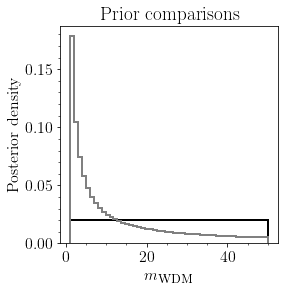

In [5]:
n = 10000000

# Sample from the respective distributions
regular_samples = np.random.uniform(1, 50, n)
scaled_samples = np.random.uniform(np.log10(1), np.log10(50), n)

# Show the plot
plt.hist(regular_samples, bins=50, histtype="step", density=True, lw=2, color="black")
plt.hist(10 ** scaled_samples, bins=50, histtype="step", density=True, lw=2, color="gray")
plt.xlabel(r"$m_\textsc{wdm}$")
plt.ylabel("Posterior density")
plt.title("Prior comparisons")
plt.minorticks_on()
make_square(plt.gca())
plt.show()

## Demonstration

### Definition of the priors

The uniform prior:

In [6]:
uniform_prior = Prior()

The log-uniform prior

In [7]:
class LogUniformPrior:

    def __init__(self, low=1.0, high=50.0):
        low = torch.tensor(low).log()
        low = low.to(hypothesis.accelerator)
        self.low = low.detach()
        high = torch.tensor(high).log()
        high = high.to(hypothesis.accelerator)
        self.high = high.detach()
        self.distribution = torch.distributions.uniform.Uniform(low, high)

    @torch.no_grad()
    def sample(self, size=(1,)):
        return self.distribution.sample(size).exp()

    @torch.no_grad()
    def log_prob(self, samples):
        log_probs = samples.clone().zero_()
        for i, s in enumerate(samples):
            if s <= self.low.exp() or s >= self.high.exp():
                log_probs[i] = -float("infinity")
            else:
                log_probs[i] = (1 / (s * (self.high - self.low))).log()
                
        return log_probs


log_uniform_prior = LogUniformPrior()

### Changing the implicit prior without retraining

The ratio estimator is trained using simulations drawn from the joint $p(\vartheta,x)$. Meaning, if you like to change the prior, you would effectively have to resimulate your dataset. However, since the ratio estimator approximates the likelihood-to-evidence ratio. We change change the prior through MCMC without retraining or resimulating data. This is possible because MCMC makes use of the likelihood-ratio to accept or reject transitions in the Markov chain. Using the ratio estimator in that case, will cancel out the (constant) evidence term. A new and arbitrary prior over $\vartheta$ can consequently be used. It should be noted however, that this prior should be supported by the original prior which the ratio estimator was trained upon.

In [8]:
ratio_estimator = load("resnet-50")

In [9]:
from hypothesis.inference.transition_distribution import Normal as NormalTransition

transition = NormalTransition(sigma=10.0) # Define a transition distribution

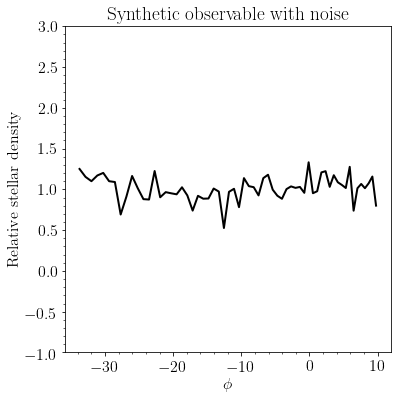

True keV:  7.726111888885498


In [10]:
# Pick a random synthetic observable
index = np.random.randint(0, len(ages))
groundtruth_age = torch.from_numpy(ages[index])
groundtruth_mass = torch.from_numpy(masses[index])
stellar_density = torch.from_numpy(densities[index]).float().view(1, -1)

# Show how the observable looks like
figure = plt.figure(figsize=(6, 6))
plt.title("Synthetic observable with noise")
plt.plot(phi, stellar_density.view(-1).numpy(), lw=2, color="black")
plt.xlabel(r"$\phi$")
plt.minorticks_on()
plt.ylabel("Relative stellar density")
plt.ylim([-1, 3])
make_square(plt.gca())
plt.show()

print("True keV: ", groundtruth_mass.item())

stellar_density = stellar_density.to(hypothesis.accelerator)

### Using the log-uniform prior

In [11]:
from hypothesis.inference.mcmc import AALRMetropolisHastings

prior = log_uniform_prior
sampler = AALRMetropolisHastings(prior, ratio_estimator, transition)

In [12]:
from hypothesis.visualization.mcmc import plot_trace

theta = log_uniform_prior.sample()
burnin_chain = sampler.sample(stellar_density, theta, num_samples=1000) # Initialize the burn-in chain

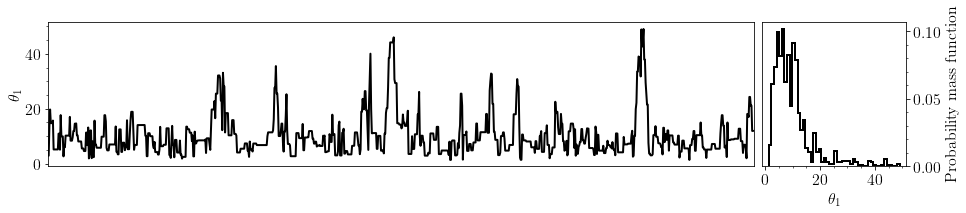

In [13]:
figure = plot_trace(burnin_chain)
plt.show()

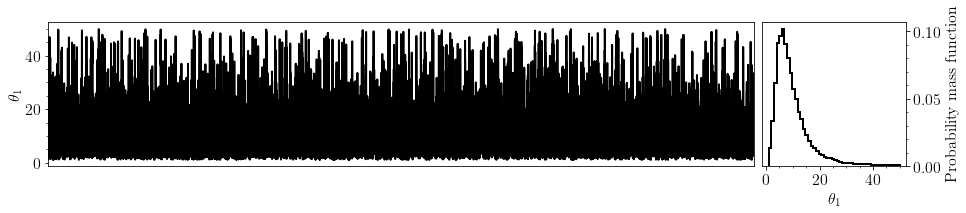

In [14]:
theta = burnin_chain[-1].cuda()
chain = sampler.sample(stellar_density, theta, num_samples=100000)
chain.samples = chain.samples.cpu()
figure = plot_trace(chain)
plt.show()

In [15]:
log_uniform_samples = chain.samples

np.percentile(log_uniform_samples, 5)

3.0527724504470832

### Using the uniform prior

In [16]:
from hypothesis.inference.mcmc import AALRMetropolisHastings

prior = uniform_prior
sampler = AALRMetropolisHastings(prior, ratio_estimator, transition)

In [17]:
from hypothesis.visualization.mcmc import plot_trace

theta = log_uniform_prior.sample()
burnin_chain = sampler.sample(stellar_density, theta, num_samples=1000)

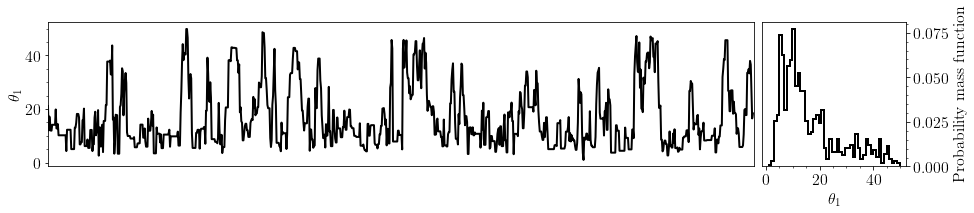

In [18]:
figure = plot_trace(burnin_chain)
plt.show()

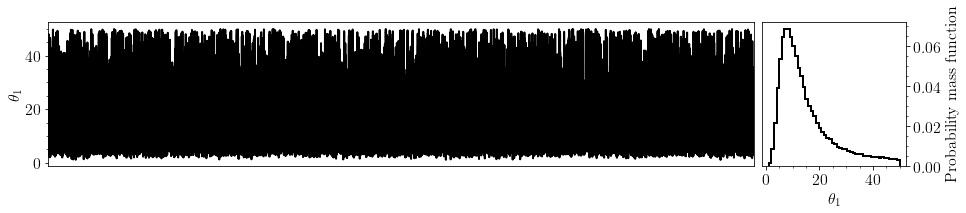

In [19]:
theta = burnin_chain[-1].cuda()
chain = sampler.sample(stellar_density, theta, num_samples=100000)
chain.samples = chain.samples.cpu()
figure = plot_trace(chain)
plt.show()

In [20]:
uniform_samples = chain.samples

np.percentile(uniform_samples, 5)

4.515231513977051